In [ ]:
import os
import pandas as pd
import cv2
import numpy as np
from tqdm import tqdm 
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score
from scipy.spatial import ConvexHull

warnings.filterwarnings('ignore')

In [2]:
asl_dataset_grayscaled = '../data/raw/asl-dataset-gray/'


In [3]:
def get_data(path):
    image_paths = []
    labels = []
    
    for label in os.listdir(path):
        label_path = os.path.join(path, label) + '/'
        if os.path.isdir(label_path):
            for img_file in os.listdir(label_path):
                image_paths.append(os.path.join(label_path, img_file))
                labels.append(label)
                
    df = pd.DataFrame({"image_path": image_paths, "label": labels})
    return df

In [4]:
grayscaled_df_path = get_data(asl_dataset_grayscaled)

In [5]:
def process_images(df, img_size=None):
    image_paths = df["image_path"].values
    labels = df["label"].values
    num_images = len(image_paths)

    if img_size is None:
        first_img = cv2.imread(image_paths[0], cv2.IMREAD_GRAYSCALE)
        height, width = first_img.shape
        vector_size = height * width
    else:
        vector_size = img_size * img_size

    image_data = np.zeros((num_images, vector_size), dtype=np.uint8)

    for i, path in tqdm(enumerate(image_paths), total=num_images, desc="Processing Images"):
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            if img_size is not None:
                img = cv2.resize(img, (img_size, img_size))
        
            image_data[i, :] = img.flatten()

    df_pixels = pd.DataFrame(image_data, columns=[f"p{i}" for i in range(vector_size)])

    df_pixels["label"] = labels

    le = LabelEncoder()
    df_pixels["encoded_label"] = le.fit_transform(labels)

    return df_pixels

In [6]:
grayscaled_df = process_images(grayscaled_df_path)

Processing Images:   0%|          | 0/26933 [00:00<?, ?it/s]

Processing Images: 100%|██████████| 26933/26933 [02:03<00:00, 217.61it/s] 


In [7]:
scaler = StandardScaler()

numeric_columns_root = grayscaled_df.columns[:-2]  
grayscaled_numeric_root = grayscaled_df[numeric_columns_root]

grayscaled_scaler_root = pd.DataFrame(
    scaler.fit_transform(grayscaled_numeric_root),
    columns=numeric_columns_root
)

grayscaled_scaler_root['label'] = grayscaled_df['label']
grayscaled_scaler_root['encoded_label'] = grayscaled_df['encoded_label']


In [8]:
print("\nPhân bố nhãn:")
label_counts = grayscaled_df['label'].value_counts()
print(label_counts)



Phân bố nhãn:
label
D    1579
E    1421
F    1247
N    1235
T    1185
B    1159
C    1153
K    1143
X    1134
S    1132
Y    1130
U    1108
G    1096
M    1082
Q    1078
I    1069
L    1047
V    1026
A    1023
H    1022
R    1021
W    1008
P     931
O     904
Name: count, dtype: int64


**Image size 64**

In [9]:
grayscaled_size64 = process_images(grayscaled_df_path, img_size=64)

Processing Images: 100%|██████████| 26933/26933 [01:56<00:00, 231.86it/s] 


In [ ]:
grayscaled_size64.to_pickle("../data/processed/resize.pkl")

In [10]:
numeric_columns = grayscaled_size64.columns[:-2]  

grayscaled_numeric = grayscaled_size64[numeric_columns]
grayscaled_scaler = pd.DataFrame(
    scaler.fit_transform(grayscaled_numeric),
    columns=numeric_columns
)

grayscaled_scaler['label'] = grayscaled_size64['label']
grayscaled_scaler['encoded_label'] = grayscaled_size64['encoded_label']

In [11]:
grayscaled_scaler

p0        p1        p2        p3        p4        p5        p6  \
0      1.553839  1.557853  1.559394  1.560493  1.563832  1.560802  1.559763   
1      1.553839  1.557853  1.559394  1.560493  1.563832  1.560802  1.559763   
2      1.553839  1.557853  1.559394  1.560493  1.563832  1.560802  1.559763   
3      1.553839  1.557853  1.559394  1.560493  1.563832  1.560802  1.559763   
4      1.553839  1.557853  1.559394  1.560493  1.563832  1.560802  1.559763   
...         ...       ...       ...       ...       ...       ...       ...   
26928  0.912968  0.914681  0.916674  0.917020  0.918288  0.917373  0.916130   
26929  0.912968  0.914681  0.916674  0.917020  0.918288  0.917373  0.916130   
26930  0.912968  0.914681  0.916674  0.917020  0.918288  0.917373  0.916130   
26931  0.912968  0.914681  0.916674  0.917020  0.918288  0.917373  0.916130   
26932  0.912968  0.914681  0.916674  0.917020  0.918288  0.917373  0.916130   

             p7        p8        p9  ...     p4088     p4089     p4090  \
0      1.565265  1.568459  1.573655  ...  2.698224  2.695670  2.706416   
1      1.565265  1.568459  1.573655  ...  2.698224  2.695670  2.706416   
2      1.565265  1.568459  1.573655  ...  2.698224  2.695670  2.706416   
3      1.565265  1.568459  1.573655  ...  2.698224  2.695670  2.706416   
4      1.565265  1.568459  1.573655  ...  2.698224  2.695670  2.706416   
...         ...       ...       ...  ...       ...       ...       ...   
26928  0.918666  0.920899  0.924196  ...  0.056089 -0.041988 -0.038541   
26929  0.918666  0.920899  0.924196  ...  0.040268 -0.010339 -0.070275   
26930  0.918666  0.920899  0.924196  ...  0.040268  0.005485 -0.070275   
26931  0.918666  0.920899  0.924196  ...  0.056089  0.021310 -0.038541   
26932  0.918666  0.920899  0.924196  ...  0.056089  0.021310 -0.022674   

          p4091     p4092     p4093     p4094     p4095  label  encoded_label  
0      2.721045  2.739339  2.765774  2.789280  2.816669      A              0  
1      2.721045  2.739339  2.765774  2.789280  2.816669      A              0  
2      2.721045  2.739339  2.765774  2.789280  2.816669      A              0  
3      2.721045  2.739339  2.765774  2.789280  2.816669      A              0  
4      2.721045  2.739339  2.765774  2.789280  2.816669      A              0  
...         ...       ...       ...       ...       ...    ...            ...  
26928  0.046507 -0.028265 -0.031611 -0.163626  0.060579      Y             23  
26929  0.030587 -0.012268 -0.031611 -0.147490  0.076791      Y             23  
26930 -0.001253  0.019728 -0.047688 -0.115218  0.060579      Y             23  
26931 -0.033092  0.035726 -0.015534 -0.115218  0.028154      Y             23  
26932 -0.112692  0.019728 -0.047688 -0.099082  0.028154      Y             23  

[26933 rows x 4098 columns]

In [ ]:
pca = PCA(n_components=1365)

X_pca = pca.fit_transform(grayscaled_scaler[numeric_columns])
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
df_pca['label'] = grayscaled_scaler['label']
df_pca['encoded_label'] = grayscaled_scaler['encoded_label']

df_pca.to_pickle("../data/processed/resize_pca_33.pkl")

In [ ]:
pca = PCA(0.95)

X_pca = pca.fit_transform(grayscaled_scaler[numeric_columns])
df_pca = pd.DataFrame(X_pca, columns=[f"PC{i+1}" for i in range(X_pca.shape[1])])
df_pca['label'] = grayscaled_scaler['label']
df_pca['encoded_label'] = grayscaled_scaler['encoded_label']


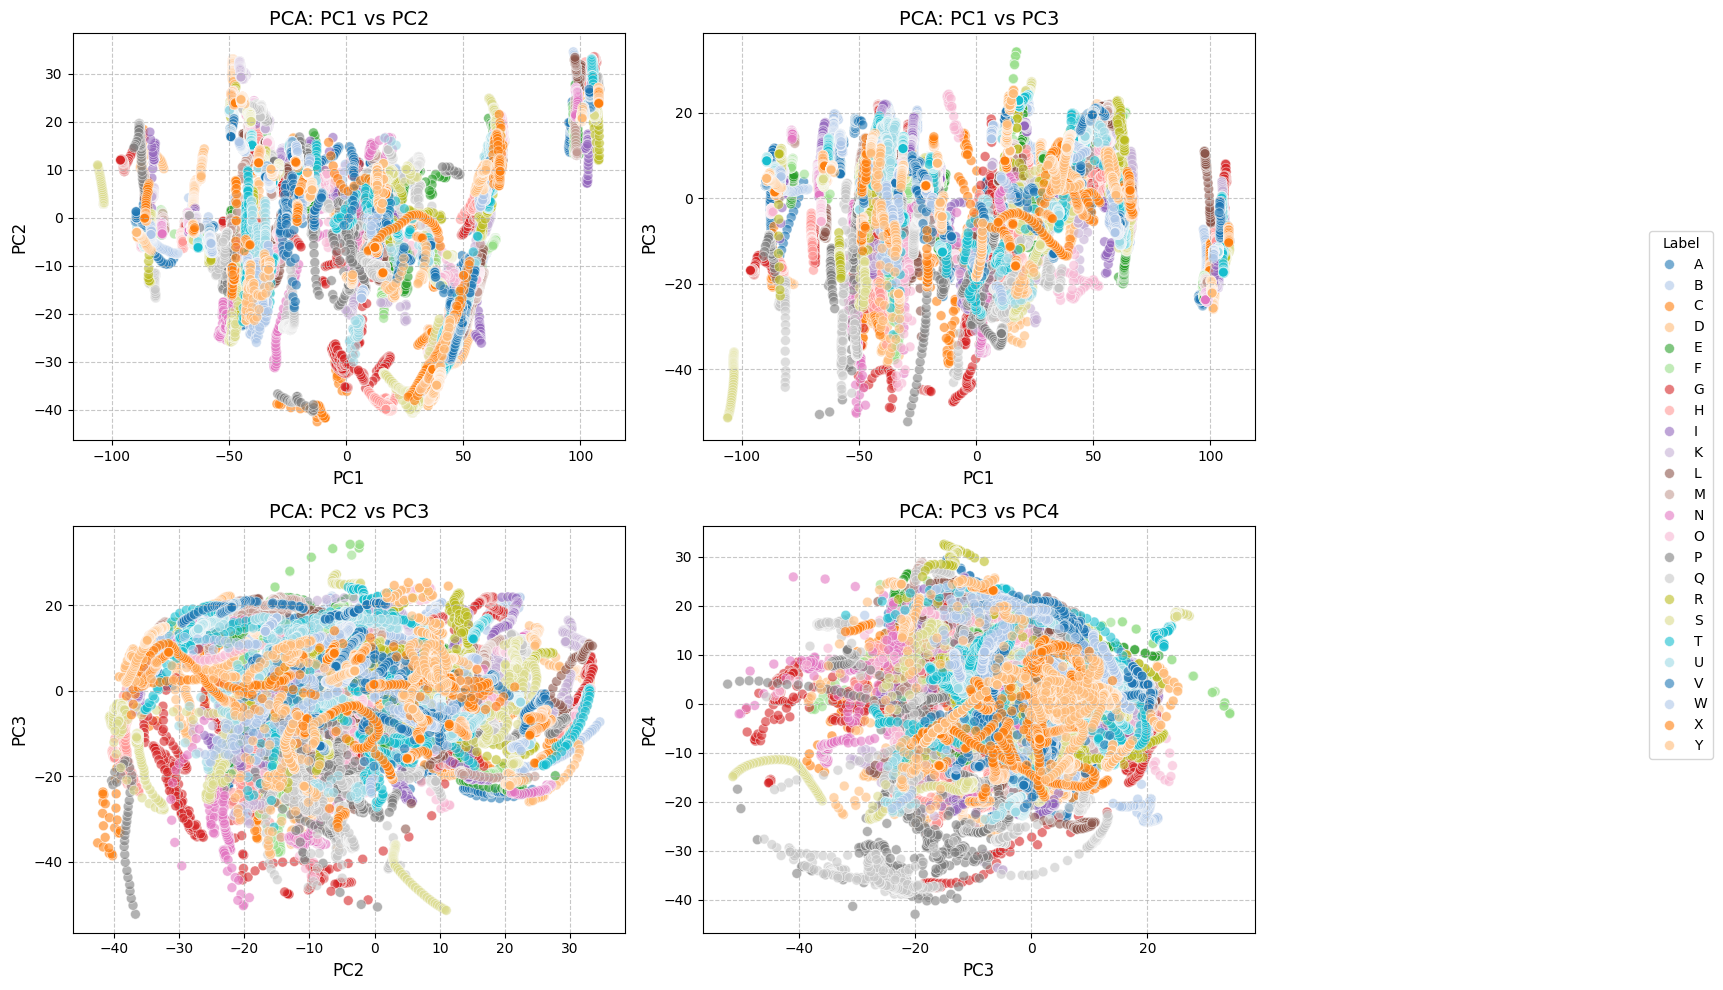

In [13]:
plt.figure(figsize=(15, 10))

pairs = [(0, 1), (0, 2), (1, 2), (2, 3)]  

handles, labels = None, None

for i, (comp1, comp2) in enumerate(pairs):
    plt.subplot(2, 2, i+1)
    scatter = sns.scatterplot(
        x=df_pca[f"PC{comp1+1}"], 
        y=df_pca[f"PC{comp2+1}"], 
        hue=df_pca['label'], 
        palette="tab20",  
        alpha=0.6,        
        s=50,             
        edgecolor='white',
        linewidth=0.5,
        legend='full' if i == len(pairs)-1 else False  
    )
    plt.title(f"PCA: PC{comp1+1} vs PC{comp2+1}", fontsize=14)
    plt.xlabel(f"PC{comp1+1}", fontsize=12)
    plt.ylabel(f"PC{comp2+1}", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7) 

    if i == len(pairs)-1:
        handles, labels = scatter.get_legend_handles_labels()
        scatter.get_legend().remove() 

plt.figlegend(handles, labels, loc='center right', bbox_to_anchor=(1.15, 0.5), title='Label', fontsize=10)

plt.tight_layout(rect=[0, 0, 0.85, 1])  
plt.show()

Phương sai giữ lại với 4 PC: 0.747321113931624
Phương sai giữ lại với 6 PC: 0.7805076259014029


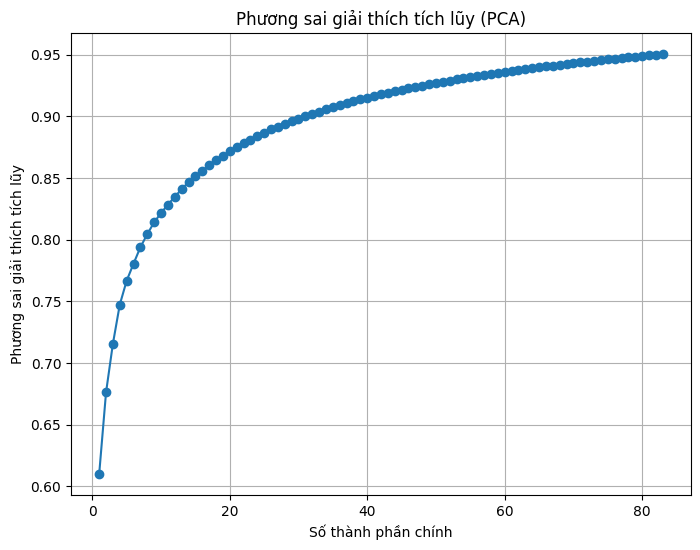

In [14]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("Phương sai giữ lại với 4 PC:", sum(explained_variance_ratio[:4]))
print("Phương sai giữ lại với 6 PC:", sum(explained_variance_ratio[:6]))

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel("Số thành phần chính")
plt.ylabel("Phương sai giải thích tích lũy")
plt.title("Phương sai giải thích tích lũy (PCA)")
plt.grid(True)
plt.show()

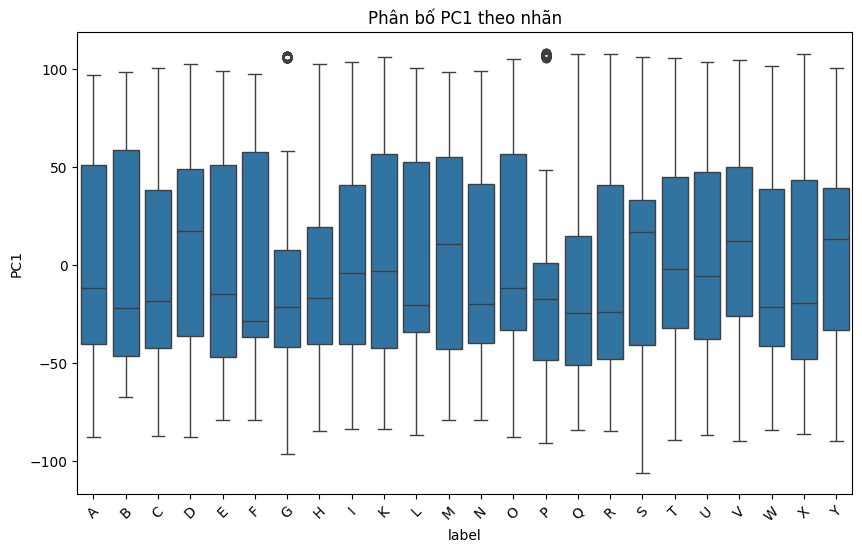

Tương quan giữa 6 PC đầu và nhãn:
PC1    0.001650
PC2   -0.029747
PC3    0.003770
PC4   -0.017794
PC5   -0.150739
PC6    0.105666
Name: encoded_label, dtype: float64


In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='label', y='PC1', data=df_pca)
plt.title("Phân bố PC1 theo nhãn")
plt.xticks(rotation=45)
plt.show()

corr = df_pca[[f"PC{i+1}" for i in range(6)] + ['encoded_label']].corr()
print("Tương quan giữa 6 PC đầu và nhãn:")
print(corr['encoded_label'][:-1])

Thời gian tính Elbow: 25.67 giây


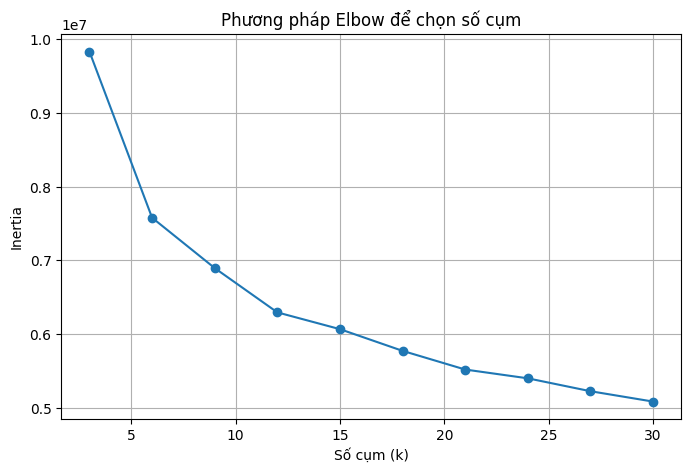

In [16]:
X_kmeans = grayscaled_scaler.drop(columns=['label', 'encoded_label']).values
labels = grayscaled_scaler['encoded_label'].values

np.random.seed(42)
sample_indices = np.random.choice(X_kmeans.shape[0], size=int(0.2 * X_kmeans.shape[0]), replace=False)
X_kmeans_sample = X_kmeans[sample_indices]

start_time = time.time()
inertia = []
K_range = [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]  
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)  
    kmeans.fit(X_kmeans_sample)  
    inertia.append(kmeans.inertia_)
print(f"Thời gian tính Elbow: {time.time() - start_time:.2f} giây")

plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Số cụm (k)')
plt.ylabel('Inertia')
plt.title('Phương pháp Elbow để chọn số cụm')
plt.grid(True)
plt.show()

Thời gian chạy K-Means: 27.79 giây
Silhouette Score: 0.1654
ARI: 0.0426
NMI: 0.2048
Phương sai giữ lại: 0.7157
Thời gian chạy PCA: 1.50 giây


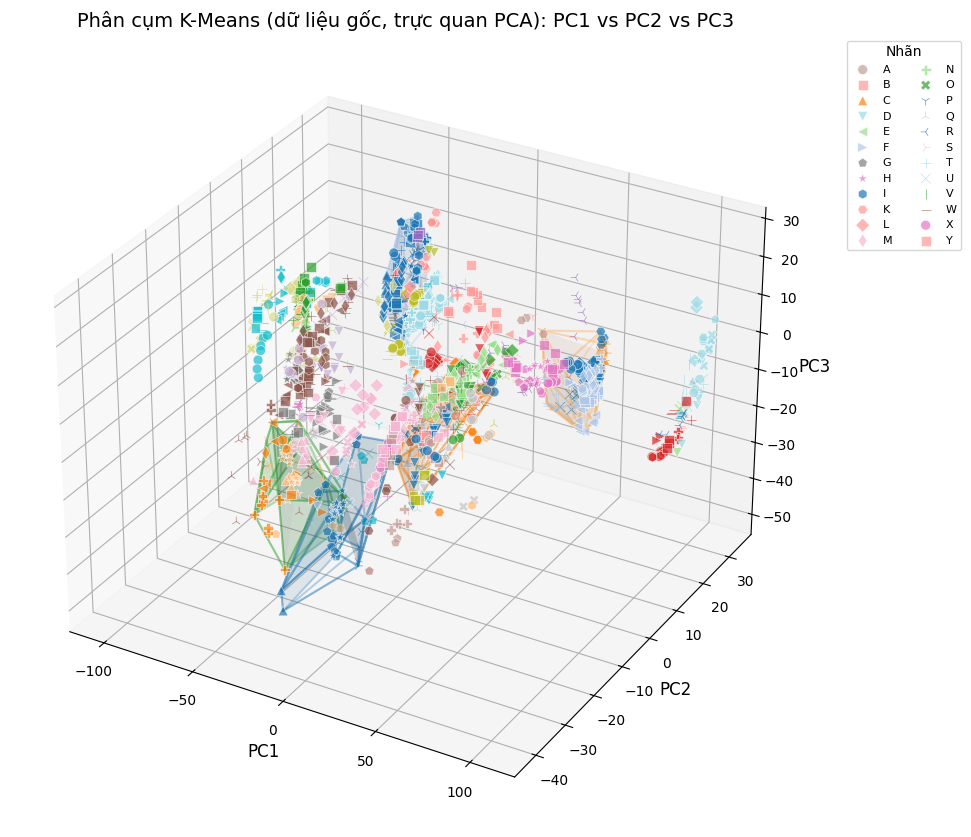


Bảng tần suất:
label    A    B    C    D    E    F    G    H    I    K  ...    P    Q    R  \
row_0                                                    ...                  
0        0    0   28    0    0    0  139  136    0    0  ...   63   10    0   
1      126  200  192    0  182  190  182  158  150    0  ...  123  188    0   
2      151    0  126  306    8    0    0    0    1    0  ...    0    0    0   
3        0  148  159  148  151  148    0    0  157  153  ...    9    0    2   
4       59    0   37   25   36   29   55  151    5    3  ...   21  100    8   
5        0    0   36    4    0   22    0    0   45   47  ...    0   35    0   
6       63  100   96   96   91   95    0    0   75   84  ...    8   23    0   
7       11   51   33  174  332    0    0    0    3  131  ...    0    0    0   
8       52   42    0   10   56   54    0    0   54    0  ...   14   42   61   
9       33   83   54   94  113   34   78   42   31   24  ...    4   37   65   
10       0    0    0    0    0    0 

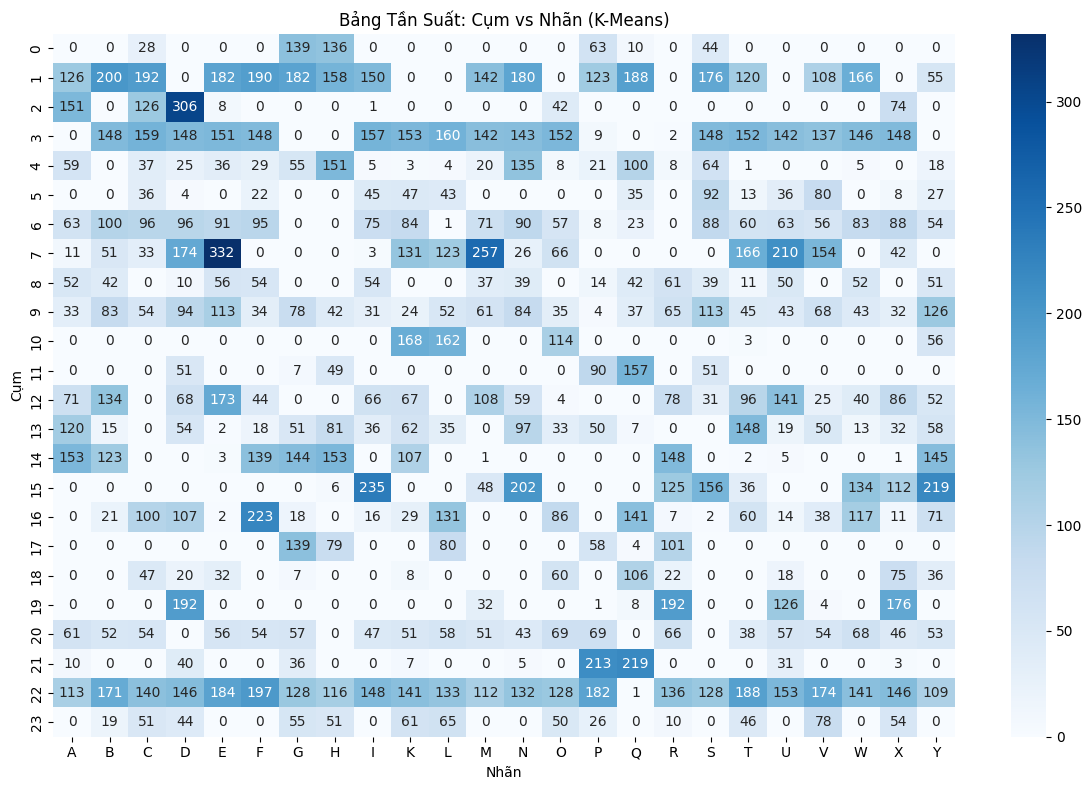

In [17]:
k_optimal = 24  
start_time = time.time()
kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_kmeans)
print(f"Thời gian chạy K-Means: {time.time() - start_time:.2f} giây")

silhouette_avg = silhouette_score(X_kmeans, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.4f}")

ari_score = adjusted_rand_score(grayscaled_scaler['encoded_label'], cluster_labels)
nmi_score = normalized_mutual_info_score(grayscaled_scaler['encoded_label'], cluster_labels)
print(f"ARI: {ari_score:.4f}")
print(f"NMI: {nmi_score:.4f}")

start_time = time.time()
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_kmeans)
print(f"Phương sai giữ lại: {sum(pca.explained_variance_ratio_):.4f}")
print(f"Thời gian chạy PCA: {time.time() - start_time:.2f} giây")

np.random.seed(42)
sample_indices = np.random.choice(len(grayscaled_scaler), 2000, replace=False)
df_sample = pd.DataFrame({
    'PC1': X_pca[sample_indices, 0],
    'PC2': X_pca[sample_indices, 1],
    'PC3': X_pca[sample_indices, 2],
    'label': grayscaled_scaler.iloc[sample_indices]['label'],
    'encoded_label': grayscaled_scaler.iloc[sample_indices]['encoded_label'],
    'cluster': cluster_labels[sample_indices]
})

markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'D', 'd',
           'P', 'X', '1', '2', '3', '4', '+', 'x', '|', '_', 'o', 's']
unique_labels = sorted(df_sample['label'].unique())

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for label, marker in zip(unique_labels, markers):
    mask = df_sample['label'] == label
    ax.scatter(
        df_sample[mask]['PC1'],
        df_sample[mask]['PC2'],
        df_sample[mask]['PC3'],
        c=df_sample[mask]['cluster'],
        cmap='tab20',
        s=50,
        alpha=0.7,
        edgecolor='white',
        linewidth=0.5,
        marker=marker,
        label=label
    )

selected_clusters = [0, 1, 2, 3, 4]
colors = sns.color_palette("tab20", n_colors=k_optimal)
for cluster in selected_clusters:
    mask = df_sample['cluster'] == cluster
    points = df_sample[mask][['PC1', 'PC2', 'PC3']].values
    if len(points) >= 4:
        try:
            hull = ConvexHull(points)
            for simplex in hull.simplices:
                ax.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2],
                        color=colors[cluster], alpha=0.3)
            ax.plot_trisurf(points[hull.vertices, 0], points[hull.vertices, 1], points[hull.vertices, 2],
                            color=colors[cluster], alpha=0.1)
        except:
            print(f"Không thể tạo bao lồi cho cụm {cluster}.")

ax.set_title("Phân cụm K-Means (dữ liệu gốc, trực quan PCA): PC1 vs PC2 vs PC3", fontsize=14)
ax.set_xlabel("PC1", fontsize=12)
ax.set_ylabel("PC2", fontsize=12)
ax.set_zlabel("PC3", fontsize=12)
ax.grid(True)
ax.legend(title='Nhãn', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8, ncol=2)
plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()

cluster_label_crosstab = pd.crosstab(cluster_labels, grayscaled_scaler['label'])
print("\nBảng tần suất:")
print(cluster_label_crosstab)

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_label_crosstab, annot=True, fmt='d', cmap='Blues')
plt.title("Bảng Tần Suất: Cụm vs Nhãn (K-Means)")
plt.xlabel("Nhãn")
plt.ylabel("Cụm")
plt.tight_layout()
plt.show()

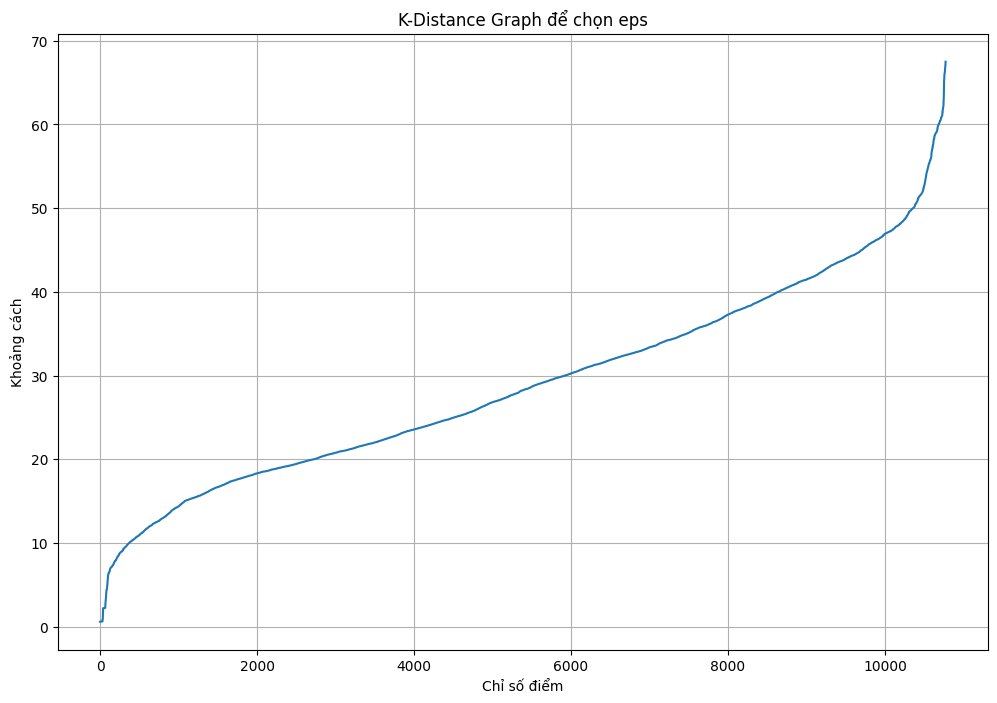

In [18]:
from sklearn.neighbors import NearestNeighbors

X_dbscan = grayscaled_scaler.drop(columns=['label', 'encoded_label']).values
labels = grayscaled_scaler['encoded_label'].values

np.random.seed(42)
sample_indices = np.random.choice(X_dbscan.shape[0], size=int(0.4 * X_dbscan.shape[0]), replace=False)
X_sample = X_dbscan[sample_indices]

min_samples_test = 30  
neighbors = NearestNeighbors(n_neighbors=min_samples_test)
neighbors_fit = neighbors.fit(X_sample)
distances, _ = neighbors_fit.kneighbors(X_sample)
distances = np.sort(distances[:, min_samples_test-1], axis=0)  

plt.figure(figsize=(12, 8))
plt.plot(list(range(1, len(distances) + 1)), distances)
# plt.axhline(y=10, color='r', linestyle='--')
# plt.text(2, 10, 'y = 10', fontsize=12, color='r')
# plt.axhline(y=20, color='g', linestyle='--')
# plt.text(2, 20, 'y = 20', fontsize=12, color='g')
plt.ylabel('Khoảng cách')
plt.xlabel('Chỉ số điểm')
plt.title('K-Distance Graph để chọn eps')
plt.grid(True)
plt.show()



In [19]:
eps_range = np.linspace(30, 40, 10)
min_samples_range = [28, 30, 33, 35]  

best_score = -1
best_params = None
results = []

start_time = time.time()

for eps in eps_range:
    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=1)  
        cluster_labels = dbscan.fit_predict(X_sample)
        unique_clusters = np.unique(cluster_labels)
        n_clusters = len(unique_clusters[unique_clusters != -1])
        noise_ratio = np.mean(cluster_labels == -1)
        
        if n_clusters > 1: 
            mask = cluster_labels != -1
            score = silhouette_score(X_sample[mask], cluster_labels[mask])
            print(f"eps={eps:.2f}, min_samples={min_samples}, Số cụm: {n_clusters}, "
                  f"Tỷ lệ nhiễu: {noise_ratio:.4f}, Silhouette Score: {score:.4f}")
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'noise_ratio': noise_ratio,
                'silhouette_score': score
            })

            if 15 <= n_clusters <= 40 and noise_ratio < 0.3 and score > best_score:
                best_score = score
                best_params = (eps, min_samples)
        else:
            print(f"eps={eps:.2f}, min_samples={min_samples}, Không đủ cụm.")
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'noise_ratio': noise_ratio,
                'silhouette_score': None
            })

print(f"\nGrid Search hoàn tất sau {time.time() - start_time:.2f} giây.")
if best_params:
    print(f"Tham số tốt nhất: eps={best_params[0]:.2f}, min_samples={best_params[1]}, "
          f"Silhouette Score: {best_score:.4f}, "
          f"Tỷ lệ nhiễu: {min(r['noise_ratio'] for r in results if r['noise_ratio'] < 0.3):.4f}")
else:
    print("Không tìm thấy tham số phù hợp với tỷ lệ nhiễu < 0.3, thử điều chỉnh eps_range hoặc min_samples_range.")



eps=30.00, min_samples=28, Số cụm: 68, Tỷ lệ nhiễu: 0.3140, Silhouette Score: 0.1996
eps=30.00, min_samples=30, Số cụm: 59, Tỷ lệ nhiễu: 0.3416, Silhouette Score: 0.2171
eps=30.00, min_samples=33, Số cụm: 42, Tỷ lệ nhiễu: 0.3957, Silhouette Score: 0.2202
eps=30.00, min_samples=35, Số cụm: 33, Tỷ lệ nhiễu: 0.4281, Silhouette Score: 0.2071
eps=31.11, min_samples=28, Số cụm: 65, Tỷ lệ nhiễu: 0.2872, Silhouette Score: 0.2272
eps=31.11, min_samples=30, Số cụm: 55, Tỷ lệ nhiễu: 0.3186, Silhouette Score: 0.2284
eps=31.11, min_samples=33, Số cụm: 42, Tỷ lệ nhiễu: 0.3635, Silhouette Score: 0.2143
eps=31.11, min_samples=35, Số cụm: 34, Tỷ lệ nhiễu: 0.3913, Silhouette Score: 0.2063
eps=32.22, min_samples=28, Số cụm: 60, Tỷ lệ nhiễu: 0.2567, Silhouette Score: 0.2722
eps=32.22, min_samples=30, Số cụm: 48, Tỷ lệ nhiễu: 0.2939, Silhouette Score: 0.3133
eps=32.22, min_samples=33, Số cụm: 39, Tỷ lệ nhiễu: 0.3247, Silhouette Score: 0.3062
eps=32.22, min_samples=35, Số cụm: 33, Tỷ lệ nhiễu: 0.3523, Silho

In [20]:
if best_params:
    print("\nChạy DBSCAN trên toàn bộ dữ liệu...")
    start_time = time.time()
    dbscan = DBSCAN(eps=best_params[0]+4, min_samples=best_params[1]+10, n_jobs=1)
    cluster_labels = dbscan.fit_predict(X_dbscan)
    
    print(f'Eps: {best_params[0]+4}            minPts: {best_params[1]+10}')

    unique_clusters = np.unique(cluster_labels)
    n_clusters = len(unique_clusters[unique_clusters != -1])
    noise_ratio = np.mean(cluster_labels == -1)
    print(f"Số cụm: {n_clusters}, Tỷ lệ nhiễu: {noise_ratio:.4f}")

    if n_clusters > 1:
        mask = cluster_labels != -1
        silhouette_avg = silhouette_score(X_dbscan[mask], cluster_labels[mask])
        print(f"Silhouette Score: {silhouette_avg:.4f}")
    else:
        print("Không đủ cụm để tính Silhouette Score.")

    ari_score = adjusted_rand_score(grayscaled_scaler['encoded_label'], cluster_labels)
    nmi_score = normalized_mutual_info_score(grayscaled_scaler['encoded_label'], cluster_labels)
    print(f"ARI: {ari_score:.4f}")
    print(f"NMI: {nmi_score:.4f}")


Chạy DBSCAN trên toàn bộ dữ liệu...
Eps: 38.44444444444444            minPts: 45
Số cụm: 55, Tỷ lệ nhiễu: 0.0856
Silhouette Score: 0.1714
ARI: 0.0157
NMI: 0.2121


Phương sai giữ lại: 0.7157


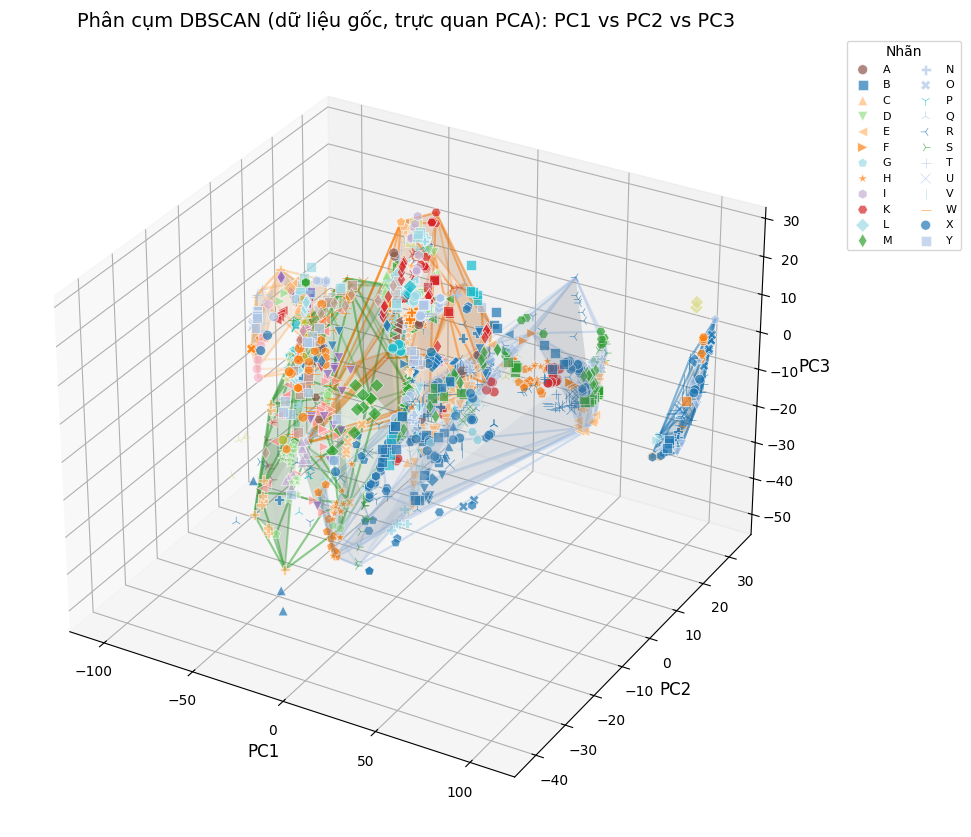


Bảng tần suất:
label    A    B    C    D    E    F    G    H    I    K  ...    P    Q    R  \
row_0                                                    ...                  
-1      87   72  132  192  113   52  111   29  121   88  ...  152  194   57   
 0      52   61   51   54   56    1   55   51   54   61  ...   40   42   71   
 1     315  322  318  628  491  287  272  295  396  391  ...    0    0  275   
 2     319  197  332  338  221  387  310  277  131  333  ...  182  142  166   
 3      55   52   16   49   56   54    0    0   47   51  ...    0    0   71   
 4     130  155  133  169  211  296  118  151   87   99  ...    0    0   93   
 5      63    0    0    0    0    0    0    0    0    0  ...    0    0    0   
 6       0  100    0    0   91    0    0    0    0    0  ...    0    0    0   
 7       0  100    0    0    0    0    0    0    0    0  ...    0    0    0   
 8       0  100   96   96   91   95    0    0   75   84  ...    0    0    0   
 9       0    0   36    0    0   22 

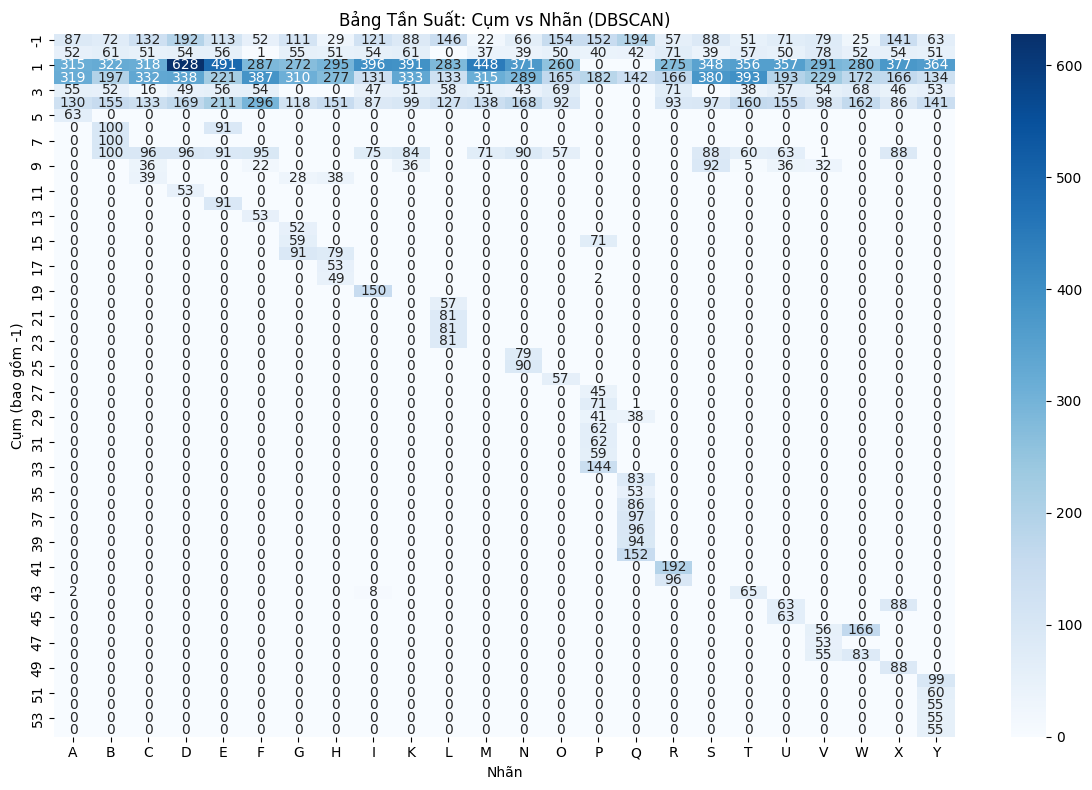

In [21]:
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_dbscan)
print(f"Phương sai giữ lại: {sum(pca.explained_variance_ratio_):.4f}")

np.random.seed(42)
sample_indices = np.random.choice(len(grayscaled_scaler), 2000, replace=False)
df_sample = pd.DataFrame({
    'PC1': X_pca[sample_indices, 0],
    'PC2': X_pca[sample_indices, 1],
    'PC3': X_pca[sample_indices, 2],
    'label': grayscaled_scaler.iloc[sample_indices]['label'],
    'encoded_label': grayscaled_scaler.iloc[sample_indices]['encoded_label'],
    'cluster': cluster_labels[sample_indices]
})

markers = ['o', 's', '^', 'v', '<', '>', 'p', '*', 'h', 'H', 'D', 'd',
           'P', 'X', '1', '2', '3', '4', '+', 'x', '|', '_', 'o', 's']
unique_labels = sorted(df_sample['label'].unique())

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for label, marker in zip(unique_labels, markers):
    mask = df_sample['label'] == label
    ax.scatter(
        df_sample[mask]['PC1'],
        df_sample[mask]['PC2'],
        df_sample[mask]['PC3'],
        c=df_sample[mask]['cluster'],
        cmap='tab20',
        s=50,
        alpha=0.7,
        edgecolor='white',
        linewidth=0.5,
        marker=marker,
        label=label
    )

unique_clusters = unique_clusters[unique_clusters != -1][:5]
colors = sns.color_palette("tab20", n_colors=len(unique_clusters))
for i, cluster in enumerate(unique_clusters):
    mask = df_sample['cluster'] == cluster
    points = df_sample[mask][['PC1', 'PC2', 'PC3']].values
    if len(points) >= 4:
        try:
            hull = ConvexHull(points)
            for simplex in hull.simplices:
                ax.plot(points[simplex, 0], points[simplex, 1], points[simplex, 2],
                        color=colors[i], alpha=0.3)
            ax.plot_trisurf(points[hull.vertices, 0], points[hull.vertices, 1], points[hull.vertices, 2],
                            color=colors[i], alpha=0.1)
        except:
            print(f"Không thể tạo bao lồi cho cụm {cluster}.")

ax.set_title("Phân cụm DBSCAN (dữ liệu gốc, trực quan PCA): PC1 vs PC2 vs PC3", fontsize=14)
ax.set_xlabel("PC1", fontsize=12)
ax.set_ylabel("PC2", fontsize=12)
ax.set_zlabel("PC3", fontsize=12)
ax.grid(True)
ax.legend(title='Nhãn', loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=8, ncol=2)
plt.tight_layout(rect=[0, 0, 0.75, 1])
plt.show()

cluster_label_crosstab = pd.crosstab(cluster_labels, grayscaled_scaler['label'])
print("\nBảng tần suất:")
print(cluster_label_crosstab)

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_label_crosstab, annot=True, fmt='d', cmap='Blues')
plt.title("Bảng Tần Suất: Cụm vs Nhãn (DBSCAN)")
plt.xlabel("Nhãn")
plt.ylabel("Cụm (bao gồm -1)")
plt.tight_layout()
plt.show()

In [22]:
df_pca.head()

PC1        PC2        PC3       PC4       PC5       PC6       PC7  \
0  96.503992  24.188073 -23.148760  6.674455 -4.474705 -6.474405  2.961791   
1  96.662305  23.476805 -23.660964  7.206289 -4.187087 -5.762798  2.674734   
2  96.849728  22.983745 -23.816838  7.328293 -3.948929 -5.059278  2.609939   
3  96.849753  22.523615 -24.279601  7.483437 -3.753943 -4.556678  2.517802   
4  96.928709  21.964923 -24.352377  8.134817 -3.522388 -4.000110  2.361141   

         PC8       PC9      PC10  ...      PC76      PC77      PC78      PC79  \
0  10.978677 -4.499586  7.683406  ... -0.541001 -1.008586 -0.100439 -0.940695   
1  10.022770 -4.428510  7.526646  ... -0.776061 -0.866251 -0.009197 -1.359460   
2   9.169886 -4.383136  7.477261  ... -0.890608 -0.683722  0.008180 -1.503957   
3   8.578503 -4.373749  7.418167  ... -0.943294 -0.552081  0.062968 -1.666936   
4   8.192019 -4.213790  7.342329  ... -1.039021 -0.412283  0.165029 -1.937748   

       PC80      PC81      PC82      PC83  label  encoded_label  
0 -0.266397 -1.124753  0.866169  0.580193      A              0  
1 -0.370919 -0.906220  0.709240  0.641172      A              0  
2 -0.453778 -0.710632  0.518060  0.706849      A              0  
3 -0.521117 -0.517157  0.344892  0.794149      A              0  
4 -0.528677 -0.414020  0.127168  0.889021      A              0  

[5 rows x 85 columns]

In [23]:
grayscaled_scaler_root.head()

p0        p1        p2       p3        p4       p5        p6      p7  \
0  1.550441  1.553329  1.555325  1.55684  1.557873  1.55789  1.557947  1.5595   
1  1.550441  1.553329  1.555325  1.55684  1.557873  1.55789  1.557947  1.5595   
2  1.550441  1.553329  1.555325  1.55684  1.557873  1.55789  1.557947  1.5595   
3  1.550441  1.553329  1.555325  1.55684  1.557873  1.55789  1.557947  1.5595   
4  1.550441  1.553329  1.555325  1.55684  1.557873  1.55789  1.557947  1.5595   

         p8        p9  ...    p16376    p16377    p16378    p16379    p16380  \
0  1.561788  1.561872  ...  2.733378  2.746747  2.762177  2.777302  2.788931   
1  1.561788  1.561872  ...  2.733378  2.746747  2.762177  2.777302  2.788931   
2  1.561788  1.561872  ...  2.733378  2.746747  2.762177  2.777302  2.788931   
3  1.561788  1.561872  ...  2.733378  2.746747  2.762177  2.777302  2.788931   
4  1.561788  1.561872  ...  2.733378  2.746747  2.762177  2.777302  2.788931   

     p16381    p16382    p16383  label  encoded_label  
0  2.798847  2.817337  2.829217      A              0  
1  2.798847  2.817337  2.829217      A              0  
2  2.798847  2.817337  2.829217      A              0  
3  2.798847  2.817337  2.829217      A              0  
4  2.798847  2.817337  2.829217      A              0  

[5 rows x 16386 columns]

In [24]:
logR = LogisticRegression(multi_class='multinomial')
nb = GaussianNB()
knn = KNeighborsClassifier(n_neighbors=7)

In [28]:
def train_model(model, X, y, train_sizes=[0.8, 0.7, 0.6], model_name="Model", random_state=1, data_type="Original"):
    results = []

    for train_size in train_sizes:
        print(f"\n=== {model_name} on {data_type} Data (Train:Validation = {int(train_size*10)}:{10 - int(train_size*10)}) ===")


        X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_size, random_state=random_state, stratify=y)


        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        training_time = end_time - start_time

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)


        val_accuracy = accuracy_score(y_val, y_val_pred)
        val_precision = precision_score(y_val, y_val_pred, average='weighted', zero_division=0)
        val_recall = recall_score(y_val, y_val_pred, average='weighted', zero_division=0)
        train_accuracy = accuracy_score(y_train, y_train_pred)


        metrics = {
            "Metric": ["Training Time (s)", "Train Accuracy", "Validation Accuracy",
                      "Validation Precision", "Validation Recall"],
            "Value": [
                f"{training_time:.2f}",
                f"{train_accuracy:.4f}",
                f"{val_accuracy:.4f}",
                f"{val_precision:.4f}",
                f"{val_recall:.4f}"
            ]
        }
        metrics_df = pd.DataFrame(metrics)

        print(metrics_df.to_string(index=False))
        print("\n")

        cm = confusion_matrix(y_val, y_val_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=np.unique(y), yticklabels=np.unique(y))
        plt.title(f"Confusion Matrix - {model_name} ({data_type}, Train:Validation = {int(train_size*10)}:{10 - int(train_size*10)})")
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()

        results.append({
            "train_size": train_size,
            "data_type": data_type,
            "train_accuracy": train_accuracy,
            "val_accuracy": val_accuracy,
            "val_precision": val_precision,
            "val_recall": val_recall,
            "training_time": training_time
        })

    return results

# Dữ liệu gốc

In [33]:
X_root = grayscaled_scaler_root.drop(['label', 'encoded_label'], axis=1)
y_root = grayscaled_scaler_root['encoded_label']

X_root = X_root.astype(np.float32)


=== Logistic Regression on Original Data (Train:Validation = 8:2) ===
              Metric  Value
   Training Time (s)  57.48
      Train Accuracy 0.9960
 Validation Accuracy 0.9792
Validation Precision 0.9793
   Validation Recall 0.9792




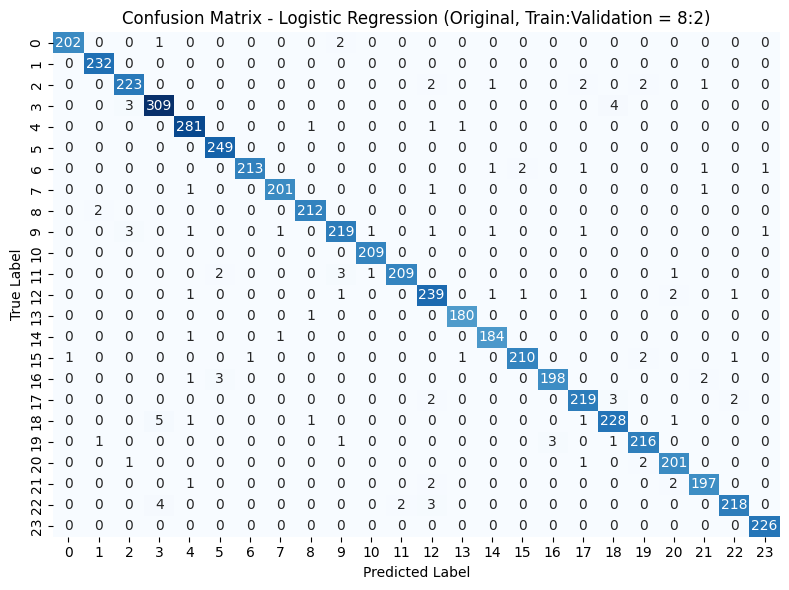


=== Logistic Regression on Original Data (Train:Validation = 7:3) ===
              Metric  Value
   Training Time (s)  43.69
      Train Accuracy 0.9969
 Validation Accuracy 0.9812
Validation Precision 0.9812
   Validation Recall 0.9812




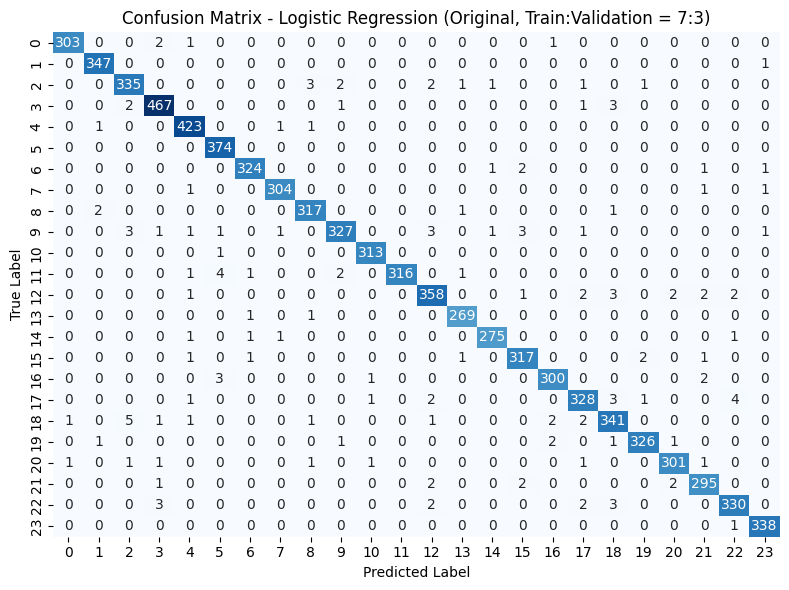


=== Logistic Regression on Original Data (Train:Validation = 6:4) ===
              Metric  Value
   Training Time (s)  35.77
      Train Accuracy 0.9981
 Validation Accuracy 0.9790
Validation Precision 0.9791
   Validation Recall 0.9790




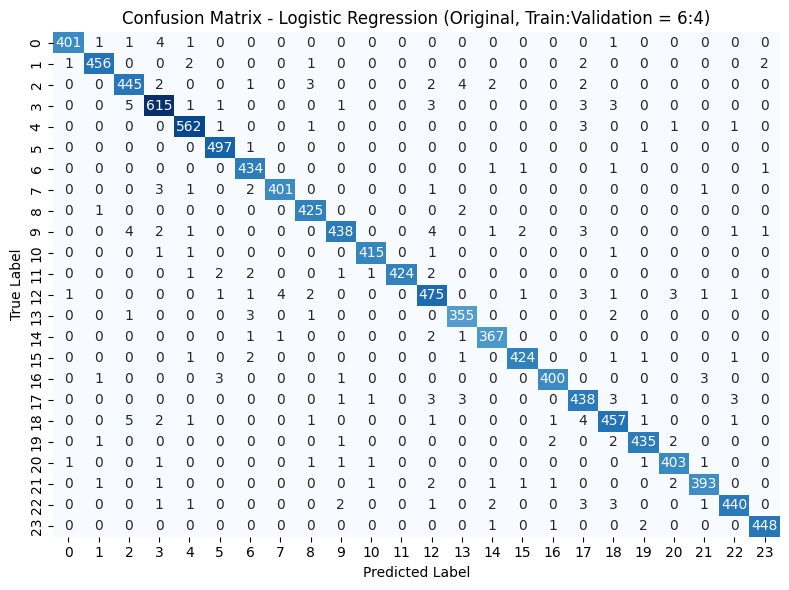

[{'train_size': 0.8,
  'data_type': 'Original',
  'train_accuracy': 0.9959621275410749,
  'val_accuracy': 0.9792092073510302,
  'val_precision': 0.9792567953763842,
  'val_recall': 0.9792092073510302,
  'training_time': 57.479684352874756},
 {'train_size': 0.7,
  'data_type': 'Original',
  'train_accuracy': 0.9968705245849467,
  'val_accuracy': 0.9811881188118812,
  'val_precision': 0.9812133391570345,
  'val_recall': 0.9811881188118812,
  'training_time': 43.69253373146057},
 {'train_size': 0.6,
  'data_type': 'Original',
  'train_accuracy': 0.9981434494708831,
  'val_accuracy': 0.9790235752738073,
  'val_precision': 0.9791004511838778,
  'val_recall': 0.9790235752738073,
  'training_time': 35.76523160934448}]

In [34]:
train_model(logR, X_root, y_root, [0.8, 0.7, 0.6], "Logistic Regression", 18, "Original")


=== Naive Bayes on Original Data (Train:Validation = 8:2) ===
              Metric  Value
   Training Time (s)   2.34
      Train Accuracy 0.1385
 Validation Accuracy 0.1355
Validation Precision 0.2604
   Validation Recall 0.1355




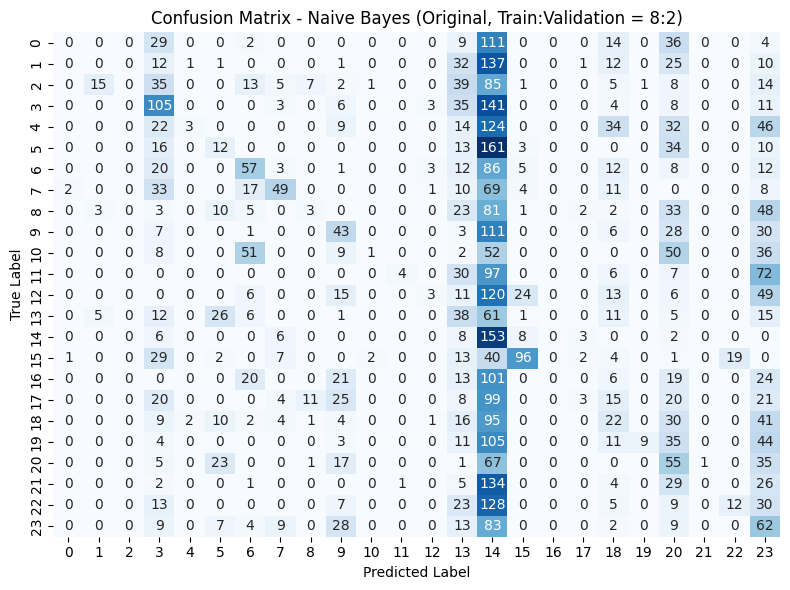


=== Naive Bayes on Original Data (Train:Validation = 7:3) ===
              Metric  Value
   Training Time (s)   2.84
      Train Accuracy 0.1314
 Validation Accuracy 0.1292
Validation Precision 0.2164
   Validation Recall 0.1292




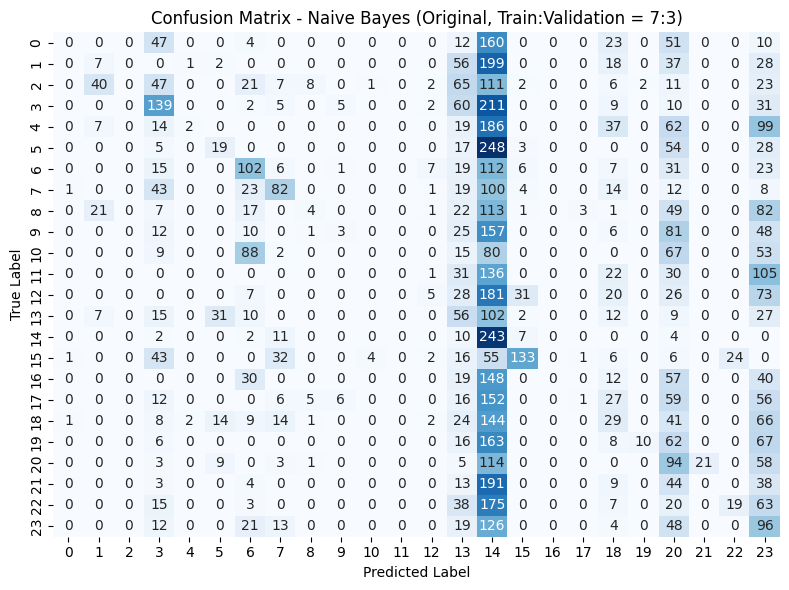


=== Naive Bayes on Original Data (Train:Validation = 6:4) ===
              Metric  Value
   Training Time (s)   2.66
      Train Accuracy 0.1266
 Validation Accuracy 0.1279
Validation Precision 0.2753
   Validation Recall 0.1279




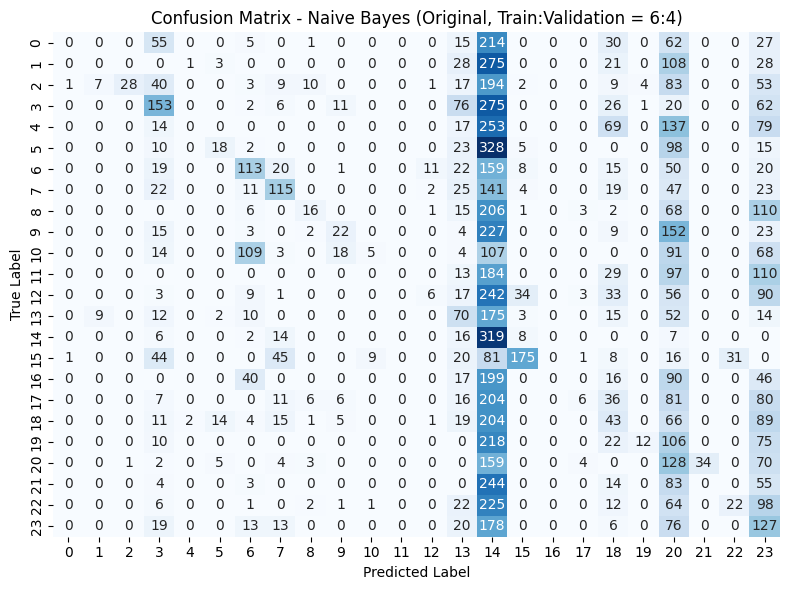

[{'train_size': 0.8,
  'data_type': 'Original',
  'train_accuracy': 0.13854079643553327,
  'val_accuracy': 0.13551141637274922,
  'val_precision': 0.2604433187958328,
  'val_recall': 0.13551141637274922,
  'training_time': 2.34175968170166},
 {'train_size': 0.7,
  'data_type': 'Original',
  'train_accuracy': 0.13138492547605155,
  'val_accuracy': 0.1292079207920792,
  'val_precision': 0.2163697082440688,
  'val_recall': 0.1292079207920792,
  'training_time': 2.843130588531494},
 {'train_size': 0.6,
  'data_type': 'Original',
  'train_accuracy': 0.12661674608577264,
  'val_accuracy': 0.1279005012066085,
  'val_precision': 0.27528311692762647,
  'val_recall': 0.1279005012066085,
  'training_time': 2.6647138595581055}]

In [35]:
train_model(nb, X_root, y_root, [0.8, 0.7, 0.6], "Naive Bayes", 18, "Original")


=== K Nearest Neighbor on Original Data (Train:Validation = 8:2) ===
              Metric  Value
   Training Time (s)   0.30
      Train Accuracy 0.9967
 Validation Accuracy 0.9942
Validation Precision 0.9943
   Validation Recall 0.9942




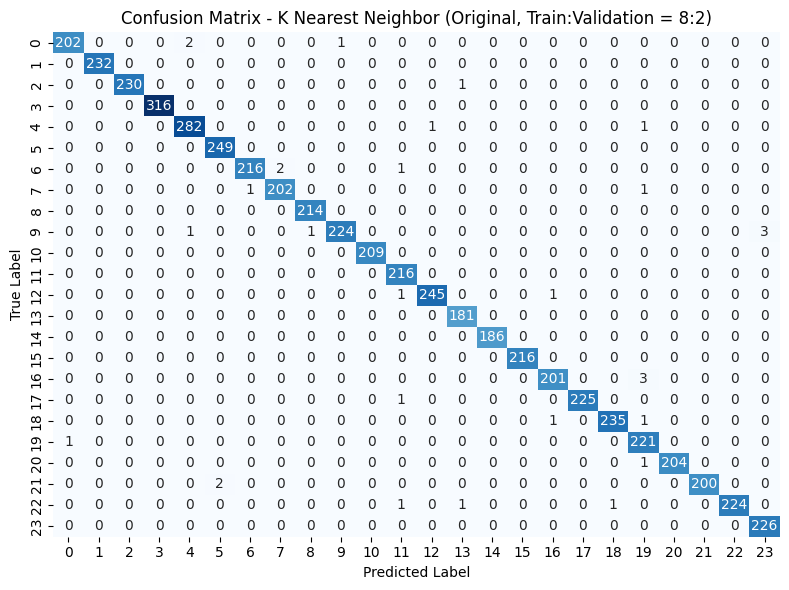


=== K Nearest Neighbor on Original Data (Train:Validation = 7:3) ===
              Metric  Value
   Training Time (s)   0.26
      Train Accuracy 0.9963
 Validation Accuracy 0.9927
Validation Precision 0.9927
   Validation Recall 0.9927




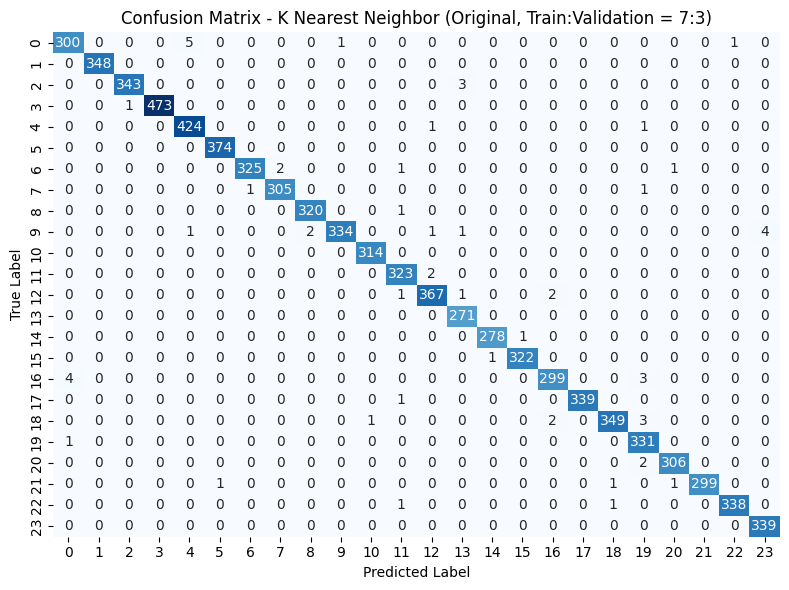


=== K Nearest Neighbor on Original Data (Train:Validation = 6:4) ===
              Metric  Value
   Training Time (s)   0.25
      Train Accuracy 0.9947
 Validation Accuracy 0.9896
Validation Precision 0.9897
   Validation Recall 0.9896




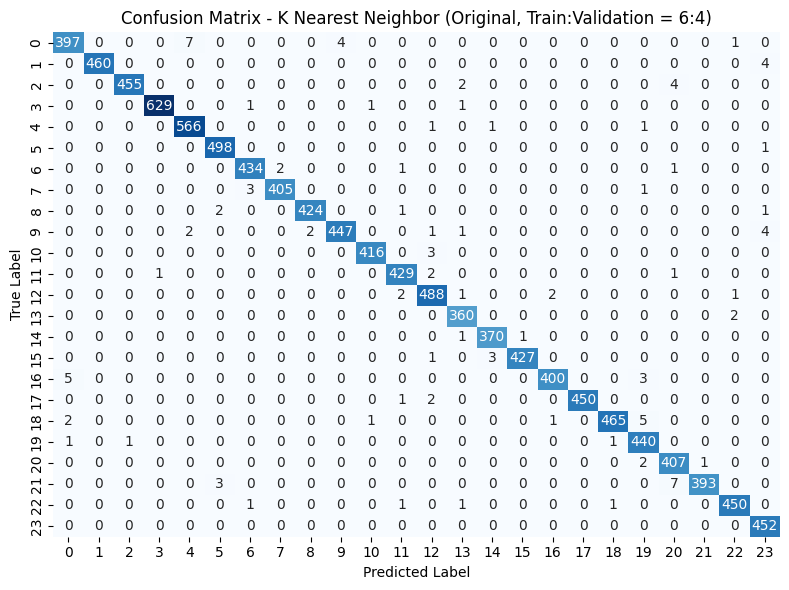

[{'train_size': 0.8,
  'data_type': 'Original',
  'train_accuracy': 0.9967047247749002,
  'val_accuracy': 0.9942454056060888,
  'val_precision': 0.9943000203519996,
  'val_recall': 0.9942454056060888,
  'training_time': 0.3000175952911377},
 {'train_size': 0.7,
  'data_type': 'Original',
  'train_accuracy': 0.9963401050230732,
  'val_accuracy': 0.9926980198019802,
  'val_precision': 0.9927447679386847,
  'val_recall': 0.9926980198019802,
  'training_time': 0.2637791633605957},
 {'train_size': 0.6,
  'data_type': 'Original',
  'train_accuracy': 0.9946778884831983,
  'val_accuracy': 0.9896046036755152,
  'val_precision': 0.9896850956993385,
  'val_recall': 0.9896046036755152,
  'training_time': 0.24667835235595703}]

In [36]:
train_model(knn, X_root, y_root, [0.8, 0.7, 0.6], "K Nearest Neighbor", 18, "Original")

# Dữ liệu PCA

In [37]:
X_pca = df_pca.drop(['label', 'encoded_label'], axis=1)
y_pca = df_pca['encoded_label']

X_pca = X_pca.astype(np.float32)


=== Logistic Regression on PCA Data (Train:Validation = 8:2) ===
              Metric  Value
   Training Time (s)   1.69
      Train Accuracy 0.8051
 Validation Accuracy 0.7763
Validation Precision 0.7771
   Validation Recall 0.7763




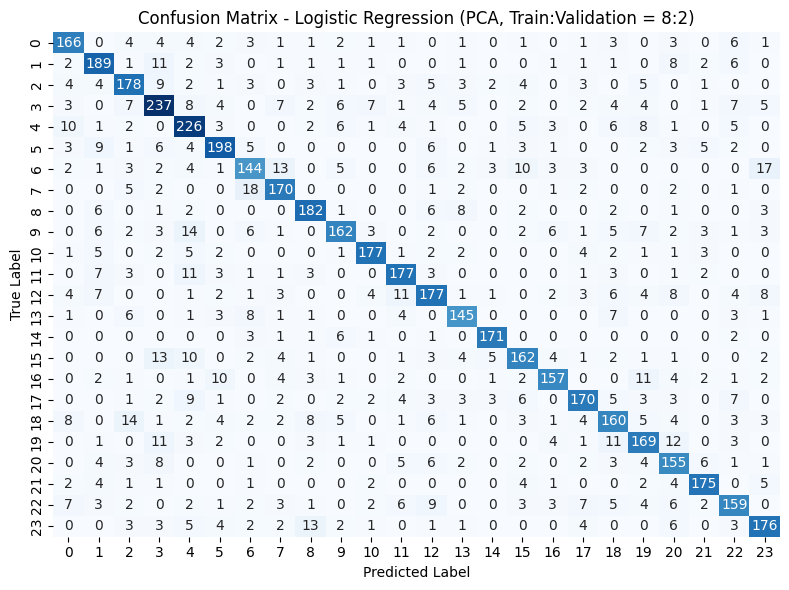


=== Logistic Regression on PCA Data (Train:Validation = 7:3) ===
              Metric  Value
   Training Time (s)   1.47
      Train Accuracy 0.8030
 Validation Accuracy 0.7865
Validation Precision 0.7871
   Validation Recall 0.7865




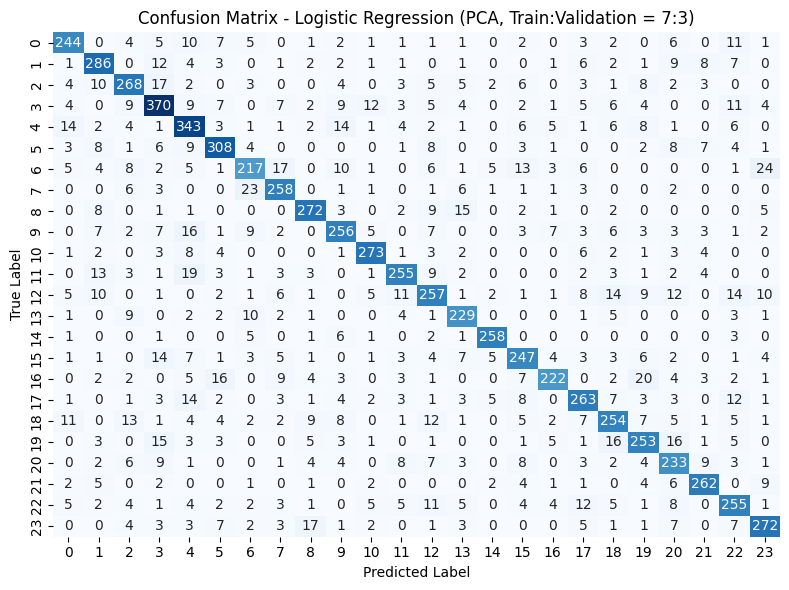


=== Logistic Regression on PCA Data (Train:Validation = 6:4) ===
              Metric  Value
   Training Time (s)   1.27
      Train Accuracy 0.8023
 Validation Accuracy 0.7853
Validation Precision 0.7858
   Validation Recall 0.7853




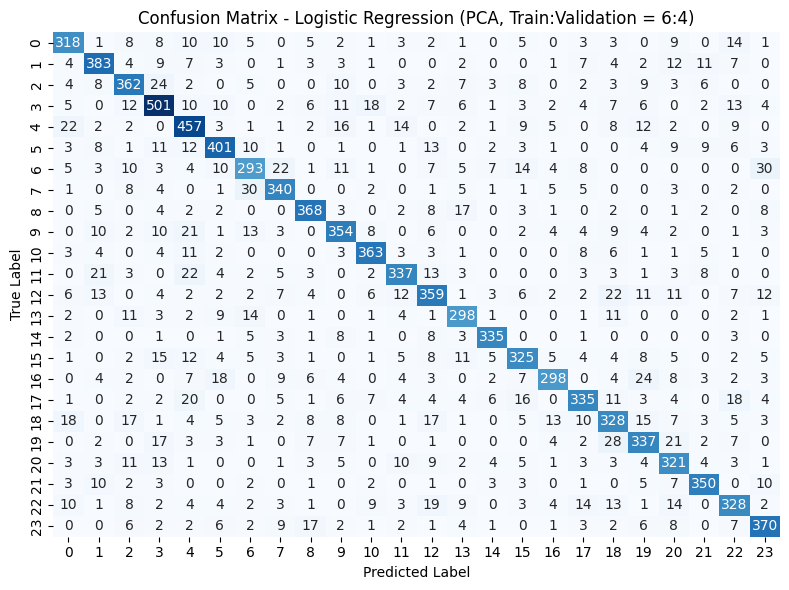

[{'train_size': 0.8,
  'data_type': 'PCA',
  'train_accuracy': 0.8050682261208577,
  'val_accuracy': 0.7763133469463523,
  'val_precision': 0.7770978175448827,
  'val_recall': 0.7763133469463523,
  'training_time': 1.6850435733795166},
 {'train_size': 0.7,
  'data_type': 'PCA',
  'train_accuracy': 0.8030021747202036,
  'val_accuracy': 0.786509900990099,
  'val_precision': 0.7871463547516782,
  'val_recall': 0.786509900990099,
  'training_time': 1.4673290252685547},
 {'train_size': 0.6,
  'data_type': 'PCA',
  'train_accuracy': 0.8023392536666873,
  'val_accuracy': 0.7853165026916651,
  'val_precision': 0.7858362102525487,
  'val_recall': 0.7853165026916651,
  'training_time': 1.2734153270721436}]

In [38]:
train_model(logR, X_pca, y_pca, [0.8, 0.7, 0.6], "Logistic Regression", 18, "PCA")


=== Naive Bayes on PCA Data (Train:Validation = 8:2) ===
              Metric  Value
   Training Time (s)   0.07
      Train Accuracy 0.6250
 Validation Accuracy 0.6143
Validation Precision 0.6707
   Validation Recall 0.6143




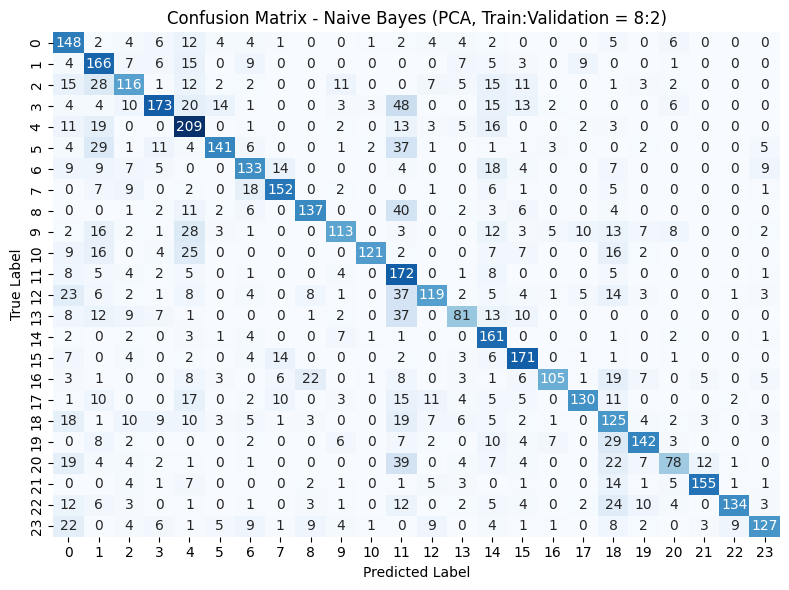


=== Naive Bayes on PCA Data (Train:Validation = 7:3) ===
              Metric  Value
   Training Time (s)   0.05
      Train Accuracy 0.6200
 Validation Accuracy 0.6113
Validation Precision 0.6675
   Validation Recall 0.6113




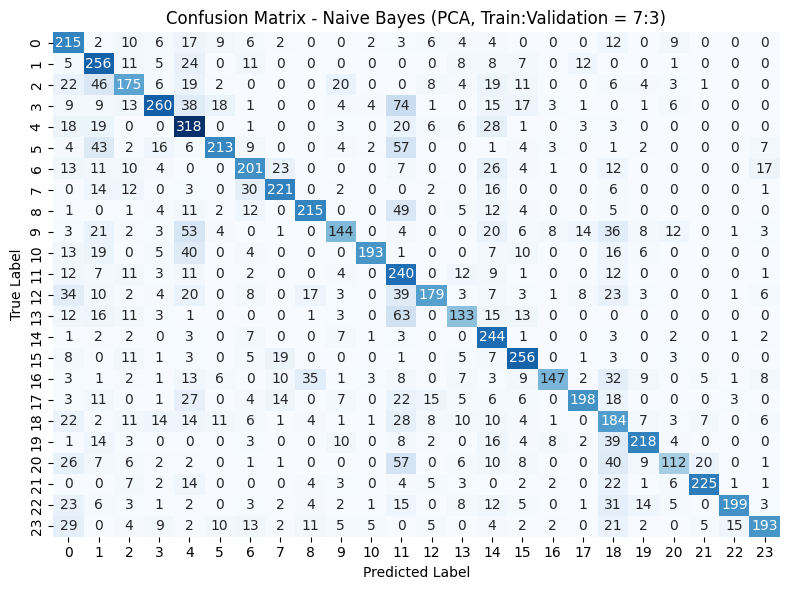


=== Naive Bayes on PCA Data (Train:Validation = 6:4) ===
              Metric  Value
   Training Time (s)   0.04
      Train Accuracy 0.6234
 Validation Accuracy 0.6065
Validation Precision 0.6640
   Validation Recall 0.6065




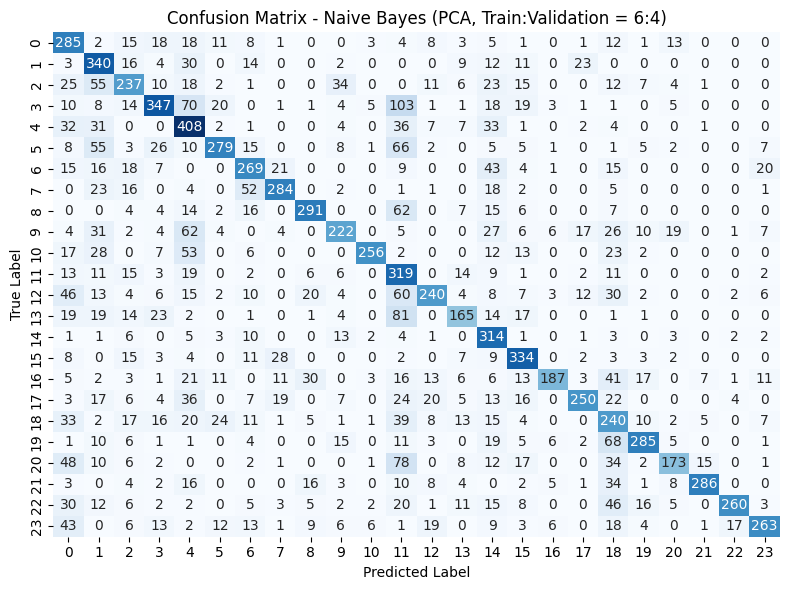

[{'train_size': 0.8,
  'data_type': 'PCA',
  'train_accuracy': 0.6250348092453356,
  'val_accuracy': 0.6142565435307221,
  'val_precision': 0.6706723531752241,
  'val_recall': 0.6142565435307221,
  'training_time': 0.06930661201477051},
 {'train_size': 0.7,
  'data_type': 'PCA',
  'train_accuracy': 0.6200074258738663,
  'val_accuracy': 0.6112623762376238,
  'val_precision': 0.6675390831160897,
  'val_recall': 0.6112623762376238,
  'training_time': 0.04768848419189453},
 {'train_size': 0.6,
  'data_type': 'PCA',
  'train_accuracy': 0.6233677826598181,
  'val_accuracy': 0.6064599962873585,
  'val_precision': 0.6639567538015311,
  'val_recall': 0.6064599962873585,
  'training_time': 0.041579484939575195}]

In [39]:
train_model(nb, X_pca, y_pca, [0.8, 0.7, 0.6], "Naive Bayes", 18, "PCA")


=== K Nearest Neighbor on PCA Data (Train:Validation = 8:2) ===
              Metric  Value
   Training Time (s)   0.05
      Train Accuracy 0.9963
 Validation Accuracy 0.9935
Validation Precision 0.9936
   Validation Recall 0.9935




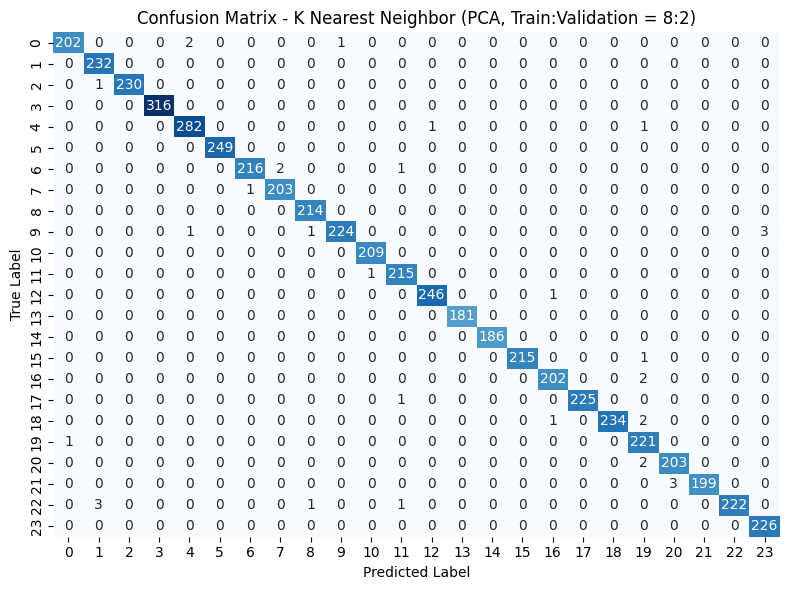


=== K Nearest Neighbor on PCA Data (Train:Validation = 7:3) ===
              Metric  Value
   Training Time (s)   0.01
      Train Accuracy 0.9961
 Validation Accuracy 0.9920
Validation Precision 0.9920
   Validation Recall 0.9920




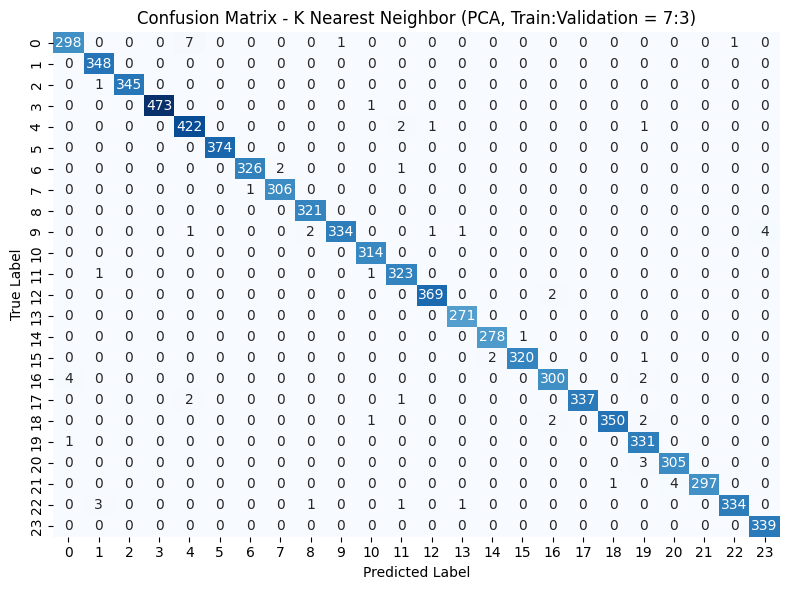


=== K Nearest Neighbor on PCA Data (Train:Validation = 6:4) ===
              Metric  Value
   Training Time (s)   0.01
      Train Accuracy 0.9949
 Validation Accuracy 0.9893
Validation Precision 0.9894
   Validation Recall 0.9893




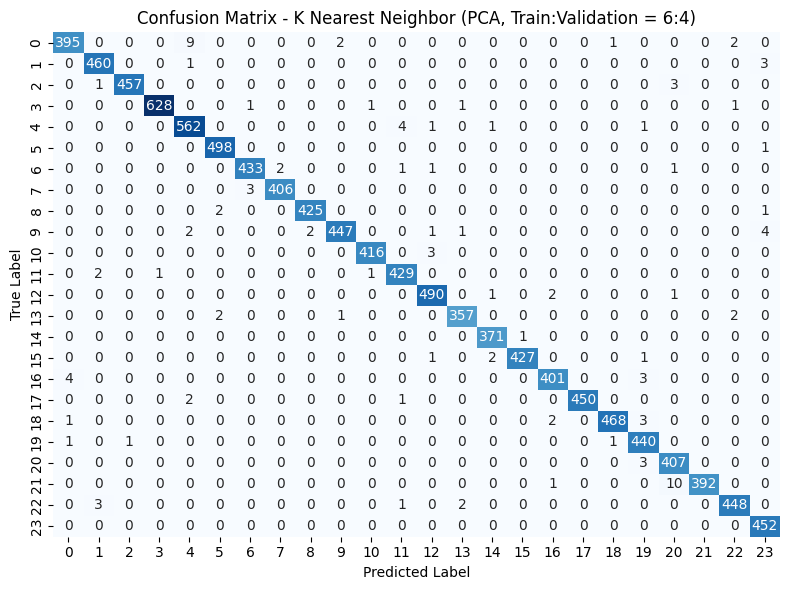

[{'train_size': 0.8,
  'data_type': 'PCA',
  'train_accuracy': 0.9962870138308735,
  'val_accuracy': 0.993502877297197,
  'val_precision': 0.9935772121217278,
  'val_recall': 0.993502877297197,
  'training_time': 0.04958081245422363},
 {'train_size': 0.7,
  'data_type': 'PCA',
  'train_accuracy': 0.9960748952421365,
  'val_accuracy': 0.9919554455445545,
  'val_precision': 0.9920119288688127,
  'val_recall': 0.9919554455445545,
  'training_time': 0.008235931396484375},
 {'train_size': 0.6,
  'data_type': 'PCA',
  'train_accuracy': 0.9949254285537471,
  'val_accuracy': 0.9893261555596807,
  'val_precision': 0.9894066818532048,
  'val_recall': 0.9893261555596807,
  'training_time': 0.007740497589111328}]

In [40]:
train_model(knn, X_pca, y_pca, [0.8, 0.7, 0.6], "K Nearest Neighbor", 18, "PCA")